# Transfer Learning and Fine-Tuning with TensorFlow

# Step 1: Import libraries


In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


# Step 2: Download and prepare the dataset

In [42]:
import os
import zipfile
import pathlib

# Check if dataset directory already exists

In [43]:
data_dir = pathlib.Path('cats_and_dogs_filtered')
if not data_dir.exists():
    print("Downloading cats and dogs dataset...")

# Download the dataset

In [44]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=False)

 # Create the directory

In [45]:
os.makedirs('cats_and_dogs_filtered', exist_ok=True)


# Manually extract the zip file

In [46]:
print("Extracting zip file...")
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall('.')
    print("Dataset extraction complete!")
    

Extracting zip file...
Dataset extraction complete!


Dataset extraction complete!


# Set path to the dataset

In [47]:
PATH = 'cats_and_dogs_filtered'

# Verify directories exist

In [48]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Print directory information to help debug

In [49]:
print(f"Train directory: {train_dir}")
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory: {validation_dir}")
print(f"Validation directory exists: {os.path.exists(validation_dir)}")


Train directory: cats_and_dogs_filtered\train
Train directory exists: True
Validation directory: cats_and_dogs_filtered\validation
Validation directory exists: True


# List subdirectories to confirm dataset structure

In [50]:
if os.path.exists(train_dir):
    print("Train subdirectories:", os.listdir(train_dir))
if os.path.exists(validation_dir):
    print("Validation subdirectories:", os.listdir(validation_dir))

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

Train subdirectories: ['cats', 'dogs']
Validation subdirectories: ['cats', 'dogs']


# Create train and validation datasets


In [51]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)




Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Class names

In [52]:
class_names = train_dataset.class_names
print("Classes:", class_names)

Classes: ['cats', 'dogs']


# Step 3: Configure the dataset for performance

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Step 4: Data augmentation

In [54]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

# Visualize a few augmented examples

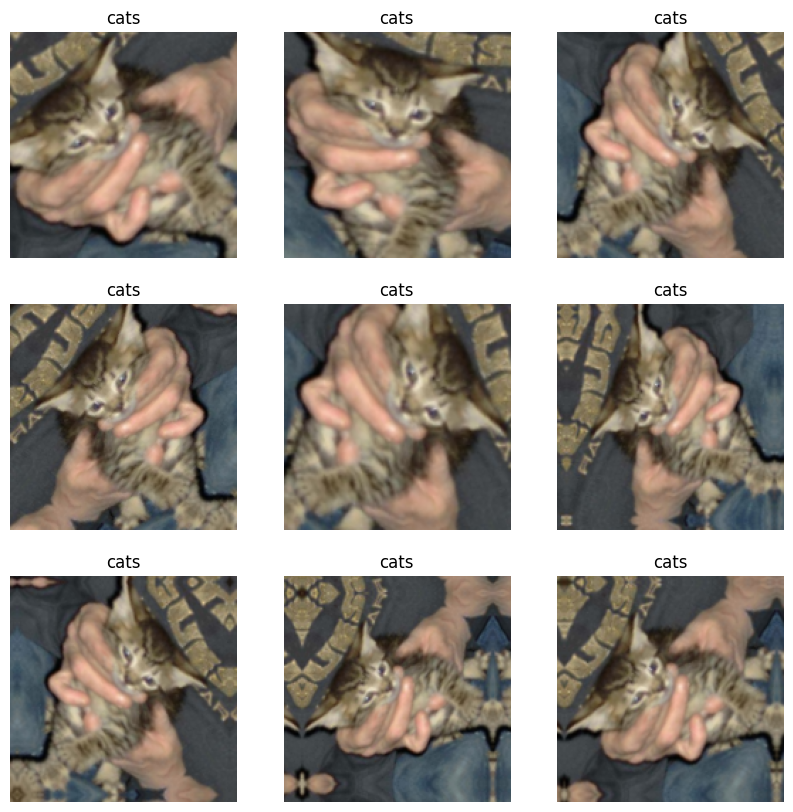

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

# Step 5: Rescale pixel values
# --------------------------
# Create a rescale layer for pixel normalization

In [56]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Step 6: Load pre-trained model
# ----------------------------
# Load MobileNetV2 without the classification head

In [57]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),  # Input shape should include color channels
    include_top=False,  # Exclude the classification head
    weights='imagenet'  # Use pre-trained weights from ImageNet
)

# Freeze the base model to prevent its weights from being updated during training

In [58]:
base_model.trainable = False

# Let's look at the base model architecture

In [59]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 7: Create the feature extractor
# Add a global average pooling layer and a dense output layer

In [60]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

# Combine all the layers into a model

In [61]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)  # Apply data augmentation
x = rescale(x)  # Rescale pixel values
x = base_model(x, training=False)  # Pass the image through the base model
x = global_average_layer(x)  # Apply global average pooling
x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout to prevent overfitting
outputs = prediction_layer(x)  # Add the dense output layer

model = tf.keras.Model(inputs, outputs)

# Step 8: Compile the model

In [62]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


# Display the model summary

In [63]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 9: Train the model
# Define callbacks

In [64]:
checkpoint_path = "training_1/cp.weights.h5"  # Changed from cp.ckpt to cp.weights.h5
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback

In [65]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

# TensorBoard setup for visualization

In [66]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1
)


# Train the model

In [67]:
initial_epochs = 10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.4573 - loss: 1.0204 
Epoch 1: saving model to training_1/cp.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.4582 - loss: 1.0185 - val_accuracy: 0.6650 - val_loss: 0.6013
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.6817 - loss: 0.6102 
Epoch 2: saving model to training_1/cp.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 932ms/step - accuracy: 0.6822 - loss: 0.6094 - val_accuracy: 0.8660 - val_loss: 0.3503
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8120 - loss: 0.4210 
Epoch 3: saving model to training_1/cp.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8120 - loss: 0.4210 - val_accuracy: 0.9370 - val_loss: 0.2385
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8415 - loss: 0.3567 
Epoch 4: saving model to training_1/cp.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8416 - loss: 0.3566 - val_accuracy: 0.9590 - val_lo

# Step 10: Learning curves
# Plot the training and validation accuracy/loss

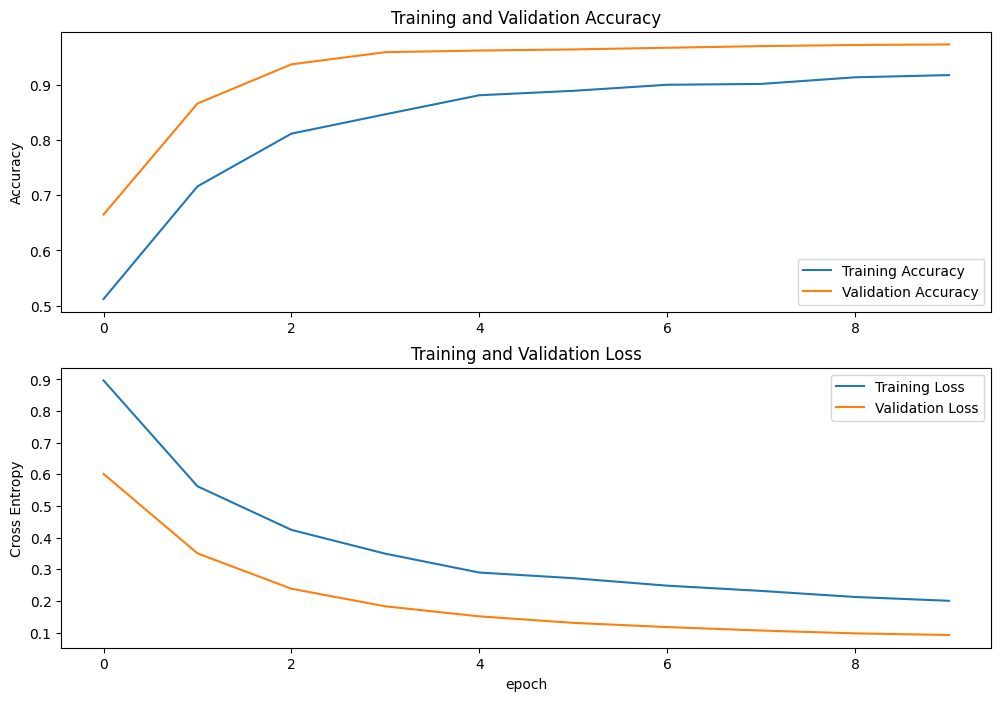

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Step 11: Fine tuning
# Un-freeze the base model for fine-tuning

In [69]:
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer

In [70]:
fine_tune_at = 100  # Choose a layer from which to fine-tune
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate

In [71]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Much lower learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# View the trainable status of each layer

In [72]:
print("Number of layers in the base model:", len(base_model.layers))
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

Number of layers in the base model: 154
0 input_layer_4 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN

# Step 12: Continue training with fine-tuning

In [73]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Start from the epoch we left off

In [ ]:
history_fine = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7873 - loss: 0.4560 

# Step 13: Learning curves with fine-tuning

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='r', linestyle='--')
plt.annotate('Start Fine Tuning', xy=(initial_epochs, 0.8), xytext=(initial_epochs, 0.65),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='r', linestyle='--')
plt.annotate('Start Fine Tuning', xy=(initial_epochs, 0.8), xytext=(initial_epochs, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# Step 14: Evaluation and prediction
# Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)

# Make predictions

In [ ]:

for image_batch, labels_batch in validation_dataset.take(1):
    images = image_batch.numpy()
    labels = labels_batch.numpy()
    predictions = model.predict(image_batch)
    
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype('uint8'))
        
        prediction = np.argmax(predictions[i])
        if prediction == labels[i]:
            color = 'green'
        else:
            color = 'red'
        
        plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[prediction]}", color=color)
        plt.axis('off')
    plt.show()


# Step 15: Save the model

In [ ]:
model.save('cats_dogs_transfer_learning_model')
print("Model saved successfully")

# Step 16: Function to predict new images

In [ ]:
def predict_image(image_path):
    """
    Make a prediction on a single image
    """
    img = tf.keras.utils.load_img(
        image_path, 
        target_size=IMG_SIZE
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

# Preprocess the image similarly to the training data

In [ ]:
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

# Make prediction

In [ ]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
confidence = np.max(predictions[0])

# Display the image and prediction

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

return class_names[predicted_class], confidence